In [1]:
import os
os.chdir("../")

In [ ]:
import warnings
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
# see available fonts
# for font in matplotlib.font_manager.fontManager.ttflist:
#     print(font.name, font.fname)

In [3]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="numpy", key=42, spectrum_type="kaimal-nd")
simulator.update_parameters(
    U_d=20.0,
    H_bar=20.0,
    alpha_0=0.12,
    z_0=0.01,
    w_up=5.0,
)

In [4]:
xs = np.linspace(0, 100, 5)
ys = np.linspace(0, 40, 5)
zs = np.linspace(50, 100, 5)
positions = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
# order these positions by norm
positions = positions[np.linalg.norm(positions, axis=1).argsort()]
wind_speeds = simulator.spectrum.calculate_mean_wind_speed(positions[:, 2], 
                                                          simulator.params["U_d"], 
                                                          simulator.params["alpha_0"])

In [5]:
samples, frequencies = simulator.simulate_wind(positions, wind_speeds, component="u",)
samples.shape

(125, 6000)

In [6]:
# simulated_mean_wind_speed = np.mean(samples, axis=1)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.scatter(positions[:, 2], wind_speeds, 
#            label="Theoretical Mean Wind Speed", color='C0', marker='o', s=80)

In [7]:
frequencies_theory = simulator.calculate_simulation_frequency(
    simulator.params["N"], simulator.params["dw"]
)
S_theory = np.zeros((len(frequencies_theory), len(positions)), dtype=np.float32)
for freq_idx, freq in enumerate(frequencies_theory):
    S_theory[freq_idx, :] = simulator.spectrum.calculate_power_spectrum(
        freq, positions[:, 2], "u"
    )

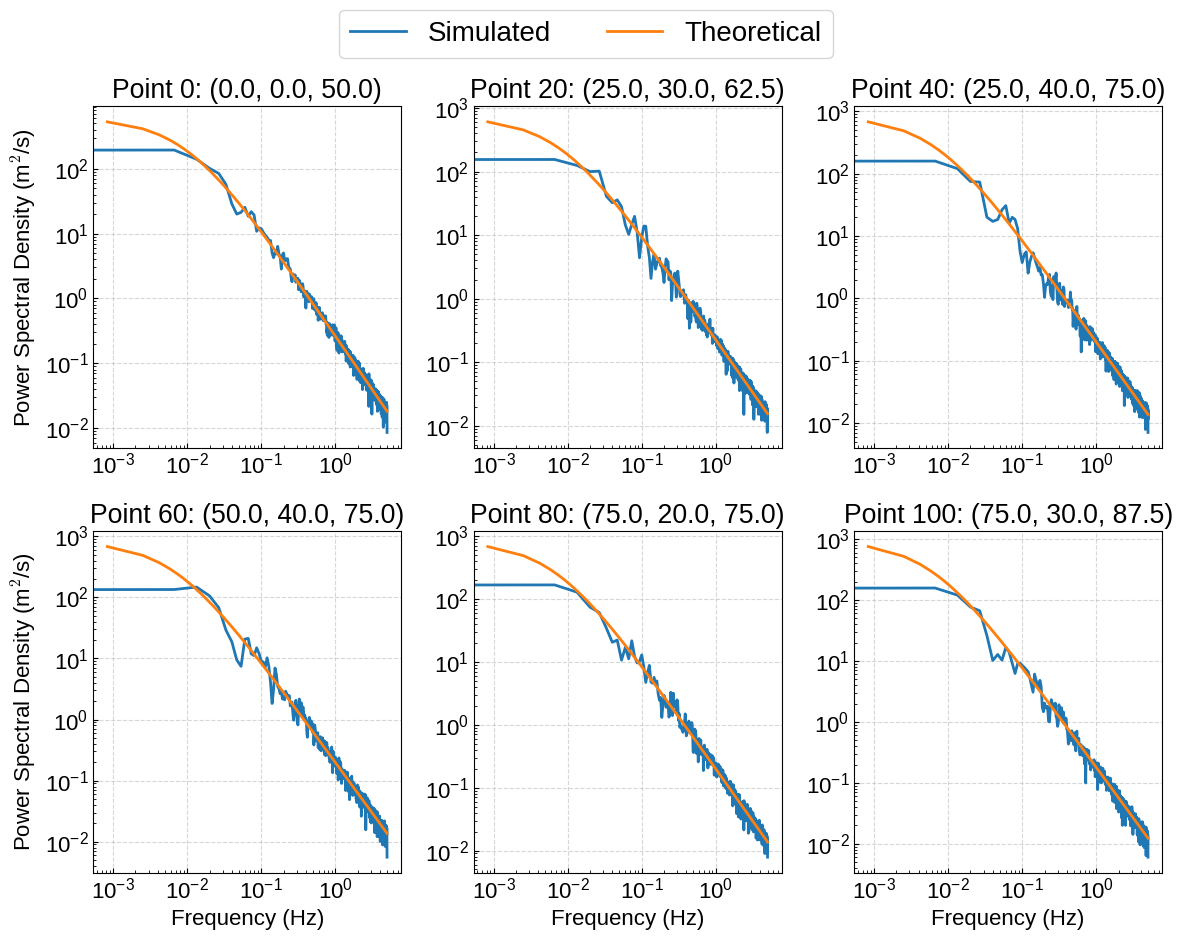

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9))
axes = axes.flatten()
indices = np.arange(0, len(positions), len(positions) // 6)[:6]
for i, idx in enumerate(indices):
    ax = axes[i]
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    ax.loglog(frequencies, psd, label="Simulated", 
              color="C0", lw=2)
    ax.loglog(
        frequencies_theory,
        S_theory[:, indices[i]],
        label="Theoretical",
        color="C1",
        lw=2
    )
    x, y, z = positions[indices[i]]
    ax.set_title(f"Point {idx}: ({x:.1f}, {y:.1f}, {z:.1f})")
    if i % 3 == 0:
        ax.set_ylabel("Power Spectral Density (m$^2$/s)")
    if i >= 3:
        ax.set_xlabel("Frequency (Hz)")

# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=20)
fig.tight_layout()
# fig.savefig("./img/validate_psd.png", dpi=300, bbox_inches='tight')
# fig.savefig("./img/validate_psd.pdf", bbox_inches='tight')
# fig.savefig("../wind_simulation_paper/validate_psd.pdf", bbox_inches='tight')


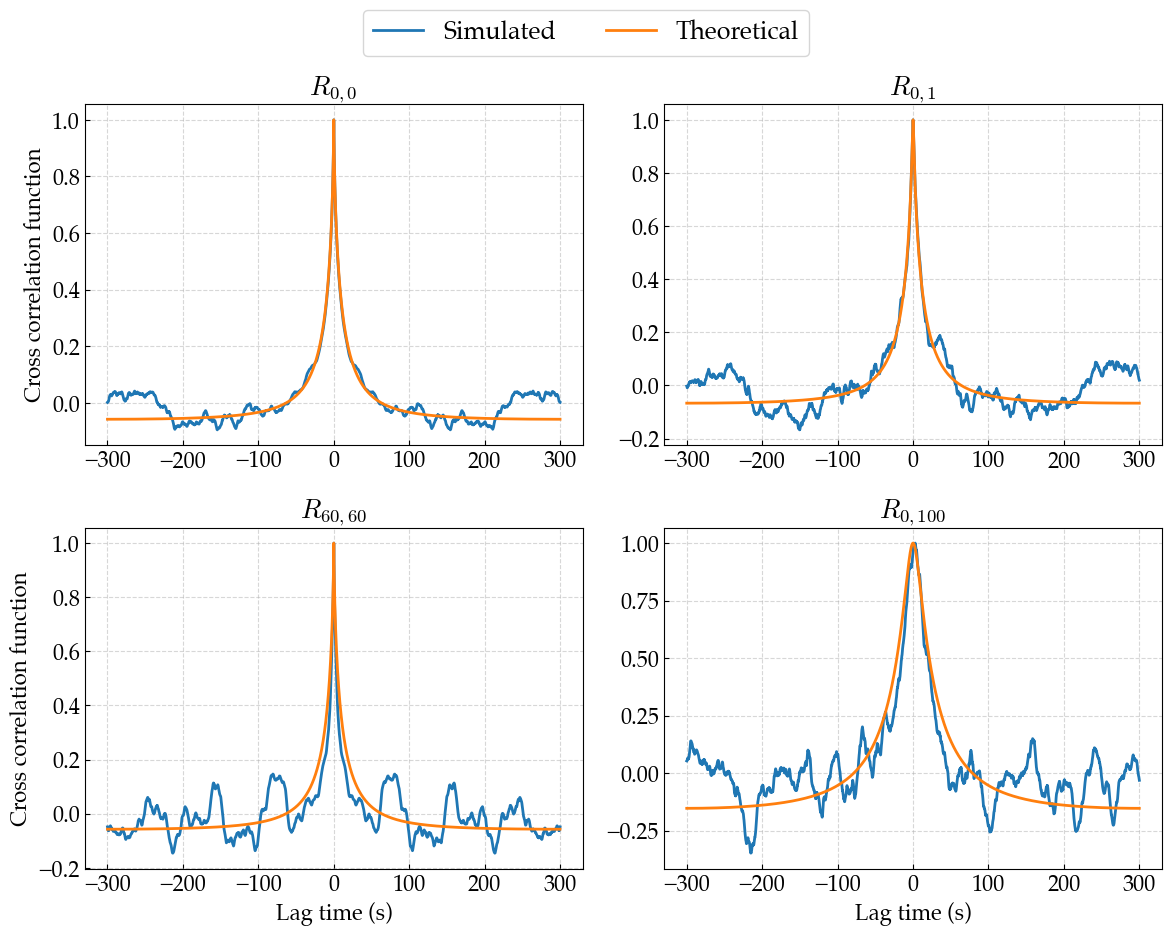

In [ ]:
pairs = [(0, 0), (0, 1), (60, 60), (0, 100)]
visualizer = get_visualizer(backend="numpy", key=42, simulator=simulator)
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()
for i, pair in enumerate(pairs):
    ax = axes[i]
    idx1, idx2 = pair

    plot_lag_times, plot_corr, theo_plot_times, theo_plot = \
        visualizer.plot_cross_correlation(
            samples,
            positions,
            wind_speeds,
            show=False,
            component="u",
            indices=pair,
            return_data=True
        )
    
    ax.plot(plot_lag_times, plot_corr, label="Simulated", color="C0", lw=2)
    ax.plot(theo_plot_times, theo_plot, label="Theoretical", color="C1", lw=2)
    x1, y1, z1 = positions[idx1]
    x2, y2, z2 = positions[idx2]
    ax.set_title(rf"$R_{{{idx1}, {idx2}}}$")
    if i % 2 == 0:
        ax.set_ylabel("Cross correlation function")
    if i >= 2:
        ax.set_xlabel("Lag time (s)")
    ax.xaxis.set_major_locator(plt.MultipleLocator(100))
# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=18)
fig.tight_layout()
# fig.savefig("./img/validate_correlation.png", dpi=300, bbox_inches='tight')
# fig.savefig("./img/validate_correlation.pdf", bbox_inches='tight')
# fig.savefig("../wind_simulation_paper/validate_correlation.pdf", bbox_inches='tight')